In [4]:
import json
import numpy as np

user_study_data = {}
probands = [0, 3, 5]

def sum_durations(timings):
    return sum(timing["duration"] for timing in timings)

for i in probands:
    for condition in ["normal", "ai"]:
        # load json file
        with open(f"user_study_results/{condition}_{i}.json", "r") as f:
            data = json.load(f)
            
        times = [sum_durations(entry["timings"]) for entry in data[5:55]]
        print(len(times))
        print(condition, np.mean(times))
        
        user_study_data[f"{condition}_{i}"] = data

50
normal 41.186240000000005
50
ai 22.93984
50
normal 39.81788
50
ai 26.373160000000002
50
normal 30.057639999999996
50
ai 22.426440000000003


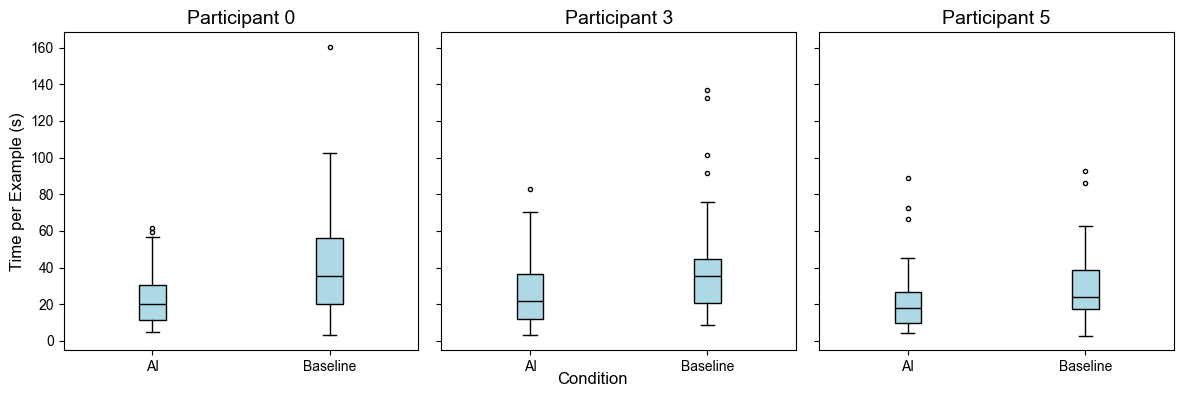

Shapiro-Wilk Test for Differences: Statistic=0.997, p=0.895
Differences are normally distributed, using paired t-test.
Paired t-test: t=-4.271, p=0.051
No significant difference at α=0.05.


In [5]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon

# Set professional style for conference paper with Arial font
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

probands = [0, 3, 5]

for idx, i in enumerate(probands):
    ai_times = [sum_durations(entry["timings"]) for entry in user_study_data[f"ai_{i}"][5:55]]
    normal_times = [sum_durations(entry["timings"]) for entry in user_study_data[f"normal_{i}"][5:55]]
    
    # Boxplot with professional styling
    bp = axes[idx].boxplot([ai_times, normal_times], tick_labels=['AI', 'Baseline'], patch_artist=True,
                           boxprops=dict(facecolor='lightblue', color='black'),
                           medianprops=dict(color='black'),
                           whiskerprops=dict(color='black'),
                           capprops=dict(color='black'),
                           flierprops=dict(marker='o', color='black', markersize=3))
    
    axes[idx].set_title(f'Participant {i}')  # Assuming participants are numbered 1,2,3
    if idx == 0:
        axes[idx].set_ylabel('Time per Example (s)')

# Overall title
# fig.suptitle('Annotation Time per Example by Participant and Condition', fontsize=16, y=1.02)

# Common x-label
fig.text(0.5, 0.02, 'Condition', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Significance test remains the same
# Sammle die Mittelwerte pro Proband
ai_means = []
normal_means = []

for i in probands:
    ai_times = [sum_durations(entry["timings"]) for entry in user_study_data[f"ai_{i}"][5:55]]
    normal_times = [sum_durations(entry["timings"]) for entry in user_study_data[f"normal_{i}"][5:55]]
    ai_means.append(np.mean(ai_times))
    normal_means.append(np.mean(normal_times))

# Differenzen
differences = np.array(ai_means) - np.array(normal_means)

# Normalitätsprüfung der Differenzen
stat, p_shapiro = shapiro(differences)
print(f"Shapiro-Wilk Test for Differences: Statistic={stat:.3f}, p={p_shapiro:.3f}")
if p_shapiro > 0.05:
    print("Differences are normally distributed, using paired t-test.")
    t_stat, p_ttest = ttest_rel(ai_means, normal_means)
    print(f"Paired t-test: t={t_stat:.3f}, p={p_ttest:.3f}")
    if p_ttest < 0.05:
        print("Significant difference at α=0.05.")
    else:
        print("No significant difference at α=0.05.")
else:
    print("Differences are not normally distributed, using Wilcoxon signed-rank test.")
    w_stat, p_wilcoxon = wilcoxon(ai_means, normal_means)
    print(f"Wilcoxon test: Statistic={w_stat:.3f}, p={p_wilcoxon:.3f}")
    if p_wilcoxon < 0.05:
        print("Significant difference at α=0.05.")
    else:
        print("No significant difference at α=0.05.")

In [6]:
ai_mean = np.mean(ai_means)
ai_std = np.std(ai_means, ddof=1)  # sample std
normal_mean = np.mean(normal_means)
normal_std = np.std(normal_means, ddof=1)

if p_shapiro > 0.05:
    normality_text = f"A Shapiro-Wilk test confirmed the normality of the differences ($W = {stat:.3f}$, $p = {p_shapiro:.3f}$)."
    test_text = f"We performed a paired $t$-test, which revealed {'a significant' if p_ttest < 0.05 else 'no significant'} difference in average annotation times per example between AI-assisted ($M = {ai_mean:.2f}$, $SD = {ai_std:.2f}$) and baseline ($M = {normal_mean:.2f}$, $SD = {normal_std:.2f}$) conditions ($t(2) = {t_stat:.3f}$, $p = {p_ttest:.3f}$)."
else:
    normality_text = f"A Shapiro-Wilk test indicated non-normality of the differences ($W = {stat:.3f}$, $p = {p_shapiro:.3f}$)."
    test_text = f"We performed a Wilcoxon signed-rank test, which revealed {'a significant' if p_wilcoxon < 0.05 else 'no significant'} difference in average annotation times per example between AI-assisted ($M = {ai_mean:.2f}$, $SD = {ai_std:.2f}$) and baseline ($M = {normal_mean:.2f}$, $SD = {normal_std:.2f}$) conditions ($W = {w_stat:.3f}$, $p = {p_wilcoxon:.3f}$)."


In [7]:
print(test_text, normality_text)

We performed a paired $t$-test, which revealed no significant difference in average annotation times per example between AI-assisted ($M = 23.91$, $SD = 2.15$) and baseline ($M = 37.02$, $SD = 6.07$) conditions ($t(2) = -4.271$, $p = 0.051$). A Shapiro-Wilk test confirmed the normality of the differences ($W = 0.997$, $p = 0.895$).
